In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from datetime import datetime
import matplotlib.pylab as plt
import calendar
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

In [2]:
df1 = pd.read_csv("dogecoin_data_uptodate.csv")
df = df1.reset_index(drop = True)

In [3]:
dict1 = {}
for i in range(len(df)):
    year = df['Date'].iloc[i].split(",")[1].split(" ")[1]
    month = list(calendar.month_abbr).index(df['Date'].iloc[i].split(",")[0].split(" ")[0])
    day = df['Date'].iloc[i].split(",")[0].split(" ")[1]
    dict1[datetime(int(year),int(month),int(day))] = df['Open*'].iloc[i]
ts = pd.DataFrame(data=dict1.values(), index=dict1.keys(), columns=["Open"])
ts = ts.sort_index()

In [4]:
train_size = int(len(ts) * 0.7)
test_size = len(ts) - train_size
test = ts.iloc[train_size:]
ts = ts.iloc[:train_size]

In [5]:
ts = ts.resample('D').mean()
ts_month = ts.resample('M').mean()
ts_year = ts.resample('A-DEC').mean()
ts_Q = ts.resample('Q-DEC').mean()

/Users/yuchenxing/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


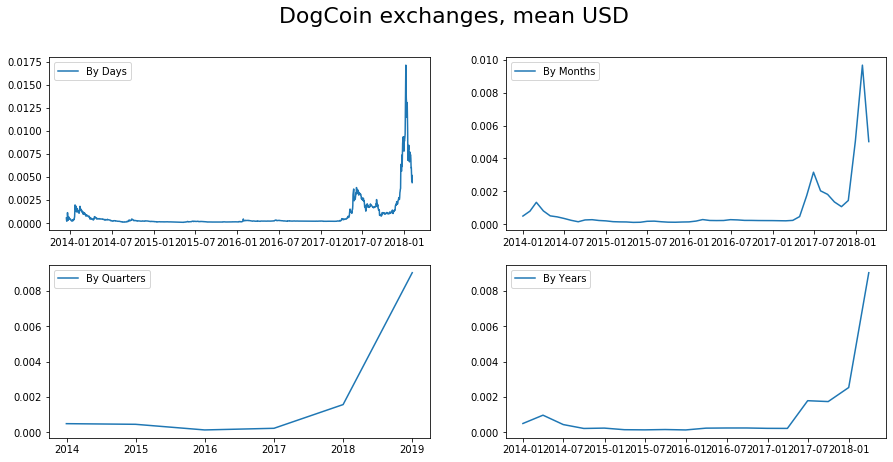

In [6]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('DogCoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(ts['Open'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(ts_month['Open'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(ts_year['Open'], '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(ts_Q['Open'], '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.905955


<Figure size 1080x504 with 0 Axes>

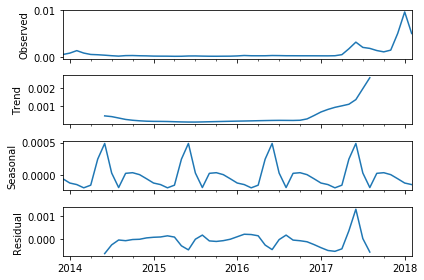

In [7]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(ts_month['Open']).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(ts_month['Open'])[1])
plt.show()

In [8]:
# Box-Cox Transformations
ts['Open_box'], lmbda = stats.boxcox(ts['Open'])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(ts['Open'])[1])

Dickey–Fuller test: p=0.000002


In [9]:
# Seasonal differentiation
ts['Open_box_diff'] = ts['Open_box'] - ts['Open_box'].shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(ts['Open_box_diff'][12:])[1])

Dickey–Fuller test: p=0.000002


Dickey–Fuller test: p=0.000000


<Figure size 1080x504 with 0 Axes>

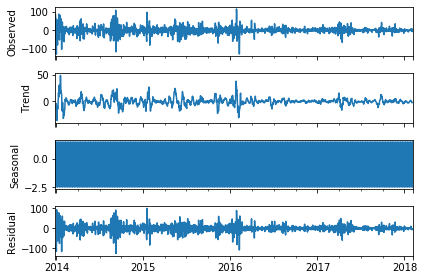

In [10]:
# Regular differentiation
ts['Open_box_diff2'] = ts.Open_box_diff - ts.Open_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(ts.Open_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(ts.Open_box_diff2[13:])[1])

plt.show()

In [11]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(ts.Open_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [12]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters           aic
49  (2, 2, 0, 1)  12297.452246
51  (2, 2, 1, 1)  12298.141812
53  (2, 2, 2, 1)  12300.118449
43  (2, 1, 0, 1)  12322.602638
45  (2, 1, 1, 1)  12324.499779
                                 Statespace Model Results                                 
Dep. Variable:                           Open_box   No. Observations:                 1514
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -6142.726
Date:                            Fri, 13 Dec 2019   AIC                          12297.452
Time:                                    19:54:39   BIC                          12329.336
Sample:                                12-15-2013   HQIC                         12309.330
                                     - 02-05-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

In [13]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

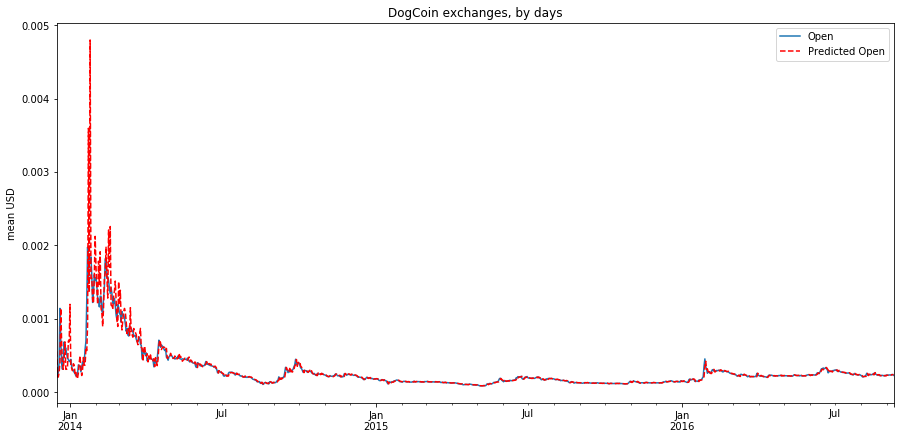

In [14]:
# Prediction
ts2 = ts[['Open']]
date_list = test.index
future = pd.DataFrame(index=date_list, columns=['Open'])
ts2 = pd.concat([ts2, future])
ts2['forecast'] = invboxcox(best_model.predict(start=0, end=1000), lmbda)
ts2 = ts2[1:1000]
plt.figure(figsize=(15,7))
ts2.Open.plot()
ts2.forecast.plot(color='r', ls='--', label='Predicted Open')
plt.legend()
plt.title('DogCoin exchanges, by days')
plt.ylabel('mean USD')
plt.show()